<a href="https://colab.research.google.com/github/Saadkhalid913/ML-Practice/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle 

In [81]:
import torchvision.transforms as transforms 
import torch.nn.functional as F 
import torch.nn as nn
import numpy as np
import os 
import matplotlib.pyplot as plt 
from PIL import Image
import google.colab.drive as drive 
from torch.utils.data import Dataset, dataloader
import torch
import tensorflow as tf 
import tqdm
from skimage.filters import threshold_multiotsu
import seaborn as sns

drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# !mkdir ../root/.kaggle
# !cp drive/MyDrive/kaggle/kaggle.json ../root/.kaggle/kaggle.json

In [5]:
import kaggle 

In [6]:
# !kaggle datasets download "dansbecker/cityscapes-image-pairs"


 96% 193M/202M [00:05<00:00, 48.5MB/s]
100% 202M/202M [00:05<00:00, 39.3MB/s]


In [ ]:
# !unzip cityscapes-image-pairs.zip

In [6]:
class UNETDataset(Dataset):

  def __init__(self):
    self.train_dir  = "cityscapes_data/train"
    self.image_names = next(os.walk(self.train_dir))[2]
    self.number_of_images = len(self.image_names)


  def __len__(self):
    return self.number_of_images

  def __getitem__(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()

      image_data = tensor_transform(image_data)

      img = image_data[: , : ,  : 256 ]
      mask = image_data[: , : , 256 : ]

      # img = image_data[: , : ,  : 128 ]
      # mask = image_data[: , : , 128 : ]

      return img, mask



In [7]:
# DS = UNETDataset()
# x,y = DS[0]
# plt.imshow(y.permute(1,2,0))

In [138]:
batch_size = 32
train_set = UNETDataset()
train_loader = dataloader.DataLoader(train_set, batch_size = batch_size, shuffle = False, )

In [123]:
def bin_image(mask):
    bins = np.arange(0,1,0.1, dtype=float)
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=256, height=256):
    seg_labels = np.zeros((classes, height, width))
    img = image[1, :, :,]

    for c in range(classes):
        seg_labels[c, :, :] = (img == c).astype(int)
    return seg_labels




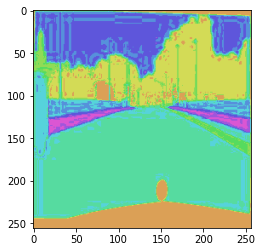

In [139]:
colors = sns.color_palette("hls", 12)
def ColorSegmentedImage(img, n_classes = 12):
  mask = np.zeros((3, 256,256), dtype = float)

  for i in range(n_classes):
    indices = (img[i] == 1)
    mask[0][indices] = colors[i][0]
    mask[1][indices] = colors[i][1]
    mask[2][indices] = colors[i][2]
  return mask



for (x,y) in train_loader:

  # print(x.shape)
  # print(y.shape)
  img = x[10]
  mask = y[10]

  binned = bin_image(mask)
  segmented = getSegmentationArr(binned, 12)
  coloured = ColorSegmentedImage(segmented, 12)
  plt.imshow(coloured.transpose(1,2,0))
  # print(np.unique(colors).shape)
  # print(np.unique(coloured).shape)



  # mask = mask.permute(1,2,0)
  # plt.imshow(mask)

  # print(torch.unique(mask.reshape(-1, mask.shape[2]), dim=0).shape)
  # print(mask.shape)


  # (fig, ax) = plt.subplots(1,2)
  # ax[0].imshow(img.permute(1,2,0))
  # ax[1].imshow(mask.permute(1,2,0))
  # fig.set_size_inches((10,10))
  # plt.show()
  break


In [75]:
img = np.zeros((3, 256,256))
img[[0], : 128, : 256] = np.full([1,128,256], fill_value = 255)
img[[2], 128: , : 256] = np.full([1,128,256], fill_value = 255)
# plt.imshow(img.transpose(1,2,0))

img = torch.tensor(img)
img = img.permute(1,2,0)
img = img.reshape(-1, img.shape[2])
print(img[:10])
# print(torch.unique(img, dim=0, return_counts = True))


tensor([[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]], dtype=torch.float64)


In [ ]:
class UNET(nn.Module):
  def __init__(self):

    super().__init__()

    self.learning_rate = 1e-4

    # batch norm 

    self.Batch_Norm = nn.BatchNorm2d(num_features=3)

    ## L1
    self.conv_1_1 = nn.Conv2d(3, 64, 3, 1,padding = "same")
    self.conv_1_2 = nn.Conv2d(64, 64, 3, 1, padding = "same")
    self.dropout_1 = nn.Dropout2d(0.2)

    self.max_pool_1 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L2
    self.conv_2_1 = nn.Conv2d(64, 128, 3, 1,padding = "same")
    self.conv_2_2 = nn.Conv2d(128, 128, 3, 1, padding = "same")
    self.dropout_2 = nn.Dropout2d(0.2)

    self.max_pool_2 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L3
    self.conv_3_1 = nn.Conv2d(128,256, 3, 1,padding = "same")
    self.conv_3_2 = nn.Conv2d(256, 256, 3, 1, padding = "same")
    self.dropout_3 = nn.Dropout2d(0.2)

    self.max_pool_3 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L4
    self.conv_4_1 = nn.Conv2d(256, 512, 3, 1,padding = "same")
    self.conv_4_2 = nn.Conv2d(512, 512, 3, 1, padding = "same")
    self.dropout_4 = nn.Dropout2d(0.2)

    self.max_pool_4 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L5
    self.conv_5_1 = nn.Conv2d(512, 1024, 1,padding = "same")
    self.conv_5_2 = nn.Conv2d(1024, 1024, 3, 1, padding = "same")
    self.dropout_5 = nn.Dropout2d(0.2)

    ##UP 1
    self.deconv1_1 = nn.ConvTranspose2d(1024, 512, 3, padding = 1, stride=2, output_padding = 1)
    self.deconv1_2 = nn.Conv2d(1024, 512, 3, 1, padding = "same")
    self.deconv1_3 = nn.Conv2d(512, 512, 3, 1, padding = "same")
    self.dropout_6 = nn.Dropout2d(0.2)


    ##UP 2
    self.deconv2_1 = nn.ConvTranspose2d(512, 256, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv2_2 = nn.Conv2d(512, 256, 3, 1, padding = "same")
    self.deconv2_3 = nn.Conv2d(256, 256, 3, 1, padding = "same")
    self.dropout_7 = nn.Dropout2d(0.2)


    ##UP 3
    self.deconv3_1 = nn.ConvTranspose2d(256, 128, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv3_2 = nn.Conv2d(256, 128, 3, 1, padding = "same")
    self.deconv3_3 = nn.Conv2d(128, 128, 3, 1, padding = "same")
    self.dropout_8 = nn.Dropout2d(0.2)


    ##UP 4
    self.deconv4_1 = nn.ConvTranspose2d(128, 64, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv4_2 = nn.Conv2d(128, 64, 3, 1, padding = 1)
    self.deconv4_3 = nn.Conv2d(64, 64, 3, 1, padding = "same")
    self.dropout_9 = nn.Dropout2d(0.2)


    ##UP 4
    self.deconv5_1 = nn.Conv2d(64, 64, 3, 1, padding = "same")
    self.deconv5_2 = nn.Conv2d(64, 3, 1, 1, padding = "same")







  def forward(self, x):
    x = self.Batch_Norm(x)
    L1_1 = self.conv_1_1(x)
    L1_1 = F.relu(L1_1)
    L1_2 = self.conv_1_2(L1_1)
    L1_2 = F.relu(L1_2)
    L1_2 = self.dropout_1(L1_2)


    L1_MAX, L1_indices = self.max_pool_1(L1_2)

    L2_1 = self.conv_2_1(L1_MAX)
    L2_1 = F.relu(L2_1)
    L2_2 = self.conv_2_2(L2_1)
    L2_2 = F.relu(L2_2)
    L2_2 = self.dropout_2(L2_2)

    L2_MAX, L2_indices = self.max_pool_2(L2_2)

    L3_1 = self.conv_3_1(L2_MAX)
    L3_1 = F.relu(L3_1)
    L3_2 = self.conv_3_2(L3_1)
    L3_2 = F.relu(L3_2)
    L3_2 = self.dropout_3(L3_2)

    L3_MAX, L3_indices = self.max_pool_3(L3_2)

    L4_1 = self.conv_4_1(L3_MAX)
    L4_1 = F.relu(L4_1)
    L4_2 = self.conv_4_2(L4_1)
    L4_2 = F.relu(L4_2)
    L4_2 = self.dropout_4(L4_2)

    L4_MAX, L4_indices = self.max_pool_4(L4_2)

    L5_1 = self.conv_5_1(L4_MAX)
    L5_1 = F.relu(L5_1)
    L5_2 = self.conv_5_2(L5_1)
    L5_2 = F.relu(L5_2)
    L5_2 = self.dropout_5(L5_2)

    ## Expansive Path

    D1_1 = self.deconv1_1(L5_2)
    skip_connection_1 = torch.cat([L4_2, D1_1], dim = 1)
    D1_2 = self.deconv1_2(skip_connection_1)
    D1_2 = F.relu(D1_2)
    D1_3 = self.deconv1_3(D1_2)
    D1_3 = F.relu(D1_3)
    D1_3 = self.dropout_6(D1_3)

    D2_1 = self.deconv2_1(D1_2)
    skip_connection_2 = torch.cat([L3_2, D2_1], dim = 1)
    D2_2 = self.deconv2_2(skip_connection_2)
    D2_2 = F.relu(D2_2)
    D2_3 = self.deconv2_3(D2_2)
    D2_3 = F.relu(D2_3)
    D2_3 = self.dropout_7(D2_3)

    D3_1 = self.deconv3_1(D2_2)
    skip_connection_3 = torch.cat([L2_2, D3_1], dim = 1)
    D3_2 = self.deconv3_2(skip_connection_3)
    D3_2 = F.relu(D3_2)
    D3_3 = self.deconv3_3(D3_2)
    D3_3 = F.relu(D3_3)
    D3_3 = self.dropout_8(D3_3)

    D4_1 = self.deconv4_1(D3_2)
    skip_connection_4 = torch.cat([L1_2, D4_1], dim = 1)
    D4_2 = self.deconv4_2(skip_connection_4)
    D4_2 = F.relu(D4_2)
    D4_3 = self.deconv4_3(D4_2)
    D4_3 = F.relu(D4_3)
    D4_3 = self.dropout_9(D4_3)

    D5_1 = self.deconv5_1(D4_2)
    D5_2 = self.deconv5_2(D5_1)
    D5_2 = torch.sigmoid(D5_2)



    return D5_2

In [ ]:
NET = UNET()
NET = NET.to(device)
Optimizer = torch.optim.Adam(NET.parameters(), lr = NET.learning_rate)
Loss = nn.CrossEntropyLoss()

EPOCHS = 10
num_batches = 100 


In [ ]:
for epoch in range(EPOCHS):
  Epoch_loss = 0
  group_loss = 0
  for i, (x,y) in enumerate(train_loader):

    if (i % 10 == 0):
      print("Batch Number: ", i + 1, " / ", len(train_loader), " LOSS: " + str(group_loss))
      group_loss = 0 
    

    x = x.to(device)
    y = y.to(device)

    output = NET(x)

    Optimizer.zero_grad()
    loss = Loss(output, y)
    loss.backward()
    Optimizer.step()

    Epoch_loss += loss.item()
    group_loss += loss.item()

  print(f"Epoch #{epoch + 1 } complete, LOSS: {Epoch_loss}")


Batch Number:  1  /  93  LOSS: 0
Batch Number:  11  /  93  LOSS: 11.529406547546387
Batch Number:  21  /  93  LOSS: 11.561365008354187
Batch Number:  31  /  93  LOSS: 11.487743735313416
Batch Number:  41  /  93  LOSS: 11.43239140510559
Batch Number:  51  /  93  LOSS: 11.391711115837097
Batch Number:  61  /  93  LOSS: 11.347877383232117
Batch Number:  71  /  93  LOSS: 11.319215059280396
Batch Number:  81  /  93  LOSS: 11.279861330986023
Batch Number:  91  /  93  LOSS: 11.339463829994202
Epoch #1 complete, LOSS: 106.05057668685913
Batch Number:  1  /  93  LOSS: 0
Batch Number:  11  /  93  LOSS: 11.15641701221466
Batch Number:  21  /  93  LOSS: 11.193411350250244
Batch Number:  31  /  93  LOSS: 11.198715567588806
Batch Number:  41  /  93  LOSS: 11.228243589401245
Batch Number:  51  /  93  LOSS: 11.217595338821411
Batch Number:  61  /  93  LOSS: 11.19710648059845
Batch Number:  71  /  93  LOSS: 11.19827115535736
Batch Number:  81  /  93  LOSS: 11.143177151679993
Batch Number:  91  /  93  L

In [ ]:
class UNETDatasetTest(Dataset):

  def __init__(self):
    self.train_dir  = "cityscapes_data/val"
    self.image_names = next(os.walk(self.train_dir))[2]
    self.number_of_images = len(self.image_names)


  def __len__(self):
    return self.number_of_images

  def __getitem__(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()
      resize_transform = transforms.Resize((64,128))

      image_data = tensor_transform(image_data)
      image_data = resize_transform(image_data)

      # img = image_data[: , : ,  : 256 ]
      # mask = image_data[: , : , 256 : ]

      img = image_data[: , : ,  : 64 ]
      mask = image_data[: , : , 64 : ]

      return img, mask

In [ ]:
# torch.save(NET.state_dict, "/saved_UNET_64x64")

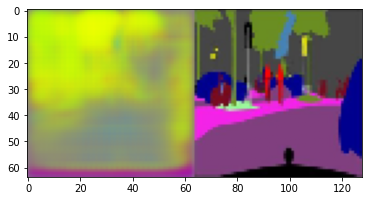

In [ ]:
testset = UNETDatasetTest()

x,y = testset[34]
x = x.unsqueeze(dim = 0)
output = NET(x.to(device))
img = output.squeeze(dim = 0).permute(1,2,0).detach().cpu().numpy()
# img = x.permute(1,2,0).detach().numpy()
mask = y.permute(1,2,0).detach().numpy()

pixels = np.concatenate((img, mask), axis = 1)
plt.imshow(pixels)
